In [1]:
import json
from collections import defaultdict
import itertools
from operator import itemgetter

import pandas as pd

%matplotlib inline

In [2]:
train_file = '../data/deft_split/jsonl/train.jsonl'
dev_file = '../data/deft_split/jsonl/dev.jsonl'

In [3]:
def extract_relations(example):
    relation_labels = example['relations']
    relation_roots = example['relation_roots']
    ner_ids = example['ner_ids']
    relations = zip(ner_ids, relation_roots, relation_labels)
    relations = filter(lambda x: x[2] != '0' and x[1] != -1, relations)
    relations = map(lambda x: (x[0], ner_ids.index(x[0]), x[1], ner_ids.index(x[1]), x[2]), relations)
    return set(relations)

def is_inter_sentence(spans, relation):
    head_idx = relation[3]
    tail_idx = relation[1]
    head_span = list(filter(lambda s: s[0] <= head_idx < s[1], spans))
    tail_span = list(filter(lambda s: s[0] <= tail_idx < s[1], spans))
    return head_span != tail_span

def get_inter_sentence_relations(spans, relations):
    return list(filter(lambda x: is_inter_sentence(spans, x), relations))

def extract_relation_schemes(relations, tags):
    relation_schemes = []
    for relation in relations:
        _, tail_offset, _, head_offset, relation_type = relation
        tail_type = tags[tail_offset][2:]
        head_type = tags[head_offset][2:]
        relation_schemes.append((tail_type, relation_type, head_type))
    return relation_schemes

In [4]:
schemes = None
with open(train_file) as f:
    for line in f.readlines():
        example = json.loads(line)
        if example['id'] == 't6_sociology_0_101.deft##12':
            relations = extract_relations(example)
            schemes = extract_relation_schemes(relations, example['tags'])
schemes

[('Definition', 'Direct-Defines', 'Term'),
 ('Referential-Term', 'Refers-To', 'Term'),
 ('Secondary-Definition', 'Supplements', 'Definition')]

In [5]:
inter_sents = None
with open(train_file) as f:
    for line in f.readlines():
        example = json.loads(line)
        if example['id'] == 't6_sociology_0_101.deft##12':
            relations = extract_relations(example)
            sentence_spans = list(map(lambda s: (s['start_token_idx'], s['end_token_idx']), example['sentence_labels']))
            inter_sents = get_inter_sentence_relations(sentence_spans, relations)
            break
inter_sents

[('T36', 40, 'T34', 12, 'Direct-Defines'),
 ('T37', 38, 'T34', 12, 'Refers-To'),
 ('T35', 19, 'T36', 40, 'Supplements')]

In [6]:
def parse_example(example):
    num_relation_types = len(set(example['relations'])) - 1
    tags = list(map(lambda x: x[2:] if x != 'O' else x, example['tags']))
    entities = set(filter(lambda x: x[1] != 'O', zip(example['ner_ids'], tags)))
    entity_types = list(map(itemgetter(1), entities))
    has_inter_sentence_relation = False
    sentence_labels = example['sentence_labels']
    has_def = any(map(lambda s: s['label'] == 'HasDef', sentence_labels))
    sentence_spans = list(map(lambda s: (s['start_token_idx'], s['end_token_idx']), sentence_labels))
    relations = extract_relations(example)
    relation_types = list(map(itemgetter(4), relations))
    relation_schemes = extract_relation_schemes(relations, example['tags'])
    inter_sentence_relations = get_inter_sentence_relations(sentence_spans, relations)
    inter_sentence_relation_types = list(map(lambda r: r[-1], inter_sentence_relations))
    return {
        'id': example['id'],
        'num_sents': len(sentence_labels),
        'num_tokens': len(example['tokens']),
        'num_entities': len(entities),
        'num_relation_types': num_relation_types,
        'num_relations': len(relations),
        'relation_types': relation_types,
        'relation_schemes': relation_schemes,
        'entity_types': entity_types,
        'has_def': has_def,
        'num_inter_sentence_relations': len(inter_sentence_relations),
        'inter_sentence_relation_types': inter_sentence_relation_types,
        'entities': list(entities),
        'relations': list(relations),
    }

In [7]:
def parse_df(file_name):
    rows = []
    with open(file_name, 'r') as f:
        for line in f.readlines():
            rows.append(parse_example(json.loads(line)))
    return pd.DataFrame(rows)

In [8]:
df = parse_df(train_file)
#df.head()

## What is the size of the dataset?

In [9]:
len(df)

5872

In [10]:
df['num_sents'].describe()

count    5872.000000
mean        2.542405
std         0.570292
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         3.000000
Name: num_sents, dtype: float64

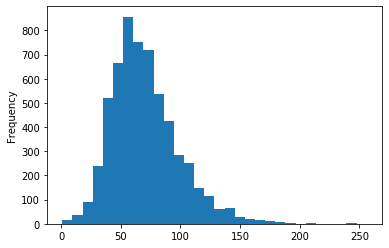

In [11]:
df['num_tokens'].plot.hist(bins=30)

In [12]:
df['num_tokens'].describe()

count    5872.000000
mean       70.099966
std        28.295098
min         1.000000
25%        51.000000
50%        66.000000
75%        85.000000
max       256.000000
Name: num_tokens, dtype: float64

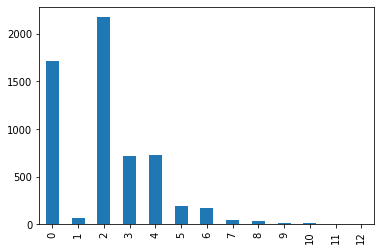

In [13]:
df['num_entities'].value_counts().sort_index().plot.bar()

In [14]:
df['num_entities'].describe()

count    5872.000000
mean        2.088556
std         1.783455
min         0.000000
25%         0.000000
50%         2.000000
75%         3.000000
max        12.000000
Name: num_entities, dtype: float64

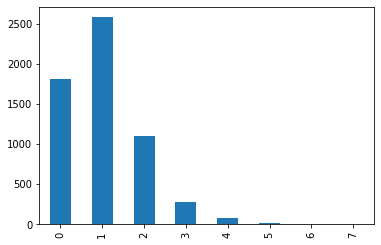

In [15]:
df['num_relations'].value_counts().sort_index().plot.bar()

In [16]:
df['num_relations'].describe()

count    5872.000000
mean        1.036274
std         0.946650
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: num_relations, dtype: float64

## How common are the entity types?

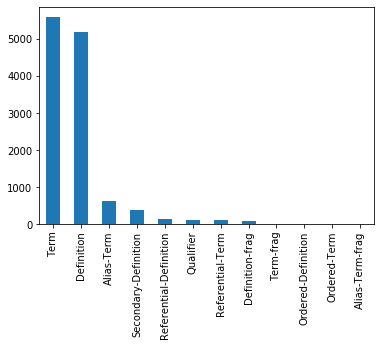

In [17]:
entity_type_counts = df.query('num_entities > 0')['entity_types'].explode().value_counts()
entity_type_counts.plot.bar()

In [18]:
entity_type_counts

Term                      5590
Definition                5183
Alias-Term                 619
Secondary-Definition       398
Referential-Definition     139
Qualifier                  127
Referential-Term           119
Definition-frag             76
Term-frag                    6
Ordered-Definition           3
Ordered-Term                 3
Alias-Term-frag              1
Name: entity_types, dtype: int64

## How common are the relation types?

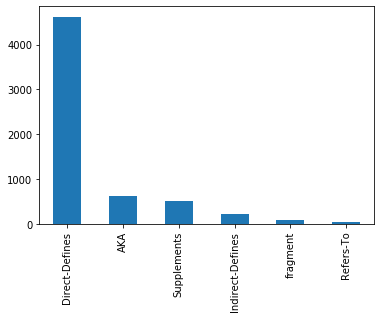

In [19]:
relation_type_counts = df.query('num_relations > 0')['relation_types'].explode().value_counts()
relation_type_counts.plot.bar()

In [20]:
relation_type_counts

Direct-Defines      4621
AKA                  617
Supplements          505
Indirect-Defines     213
fragment              83
Refers-To             46
Name: relation_types, dtype: int64

## How many relations span more than a single sentence?

In [21]:
total_inter_sentence_relations = df['num_inter_sentence_relations'].sum()
total_inter_sentence_relations

522

In [22]:
(total_inter_sentence_relations / df['num_relations'].sum()) * 100

8.578471651602301

## Which relation types span more than a single sentence?

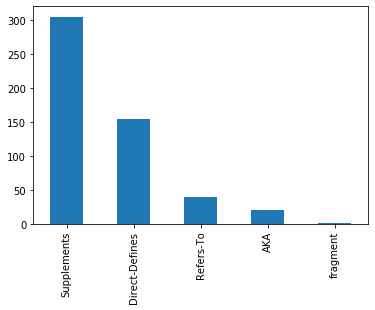

In [23]:
inter_sentence_relation_type_counts = df.query('num_inter_sentence_relations > 0')['inter_sentence_relation_types'].explode().value_counts()
inter_sentence_relation_type_counts.plot.bar()

In [24]:
inter_sentence_relation_type_counts

Supplements       305
Direct-Defines    155
Refers-To          40
AKA                21
fragment            1
Name: inter_sentence_relation_types, dtype: int64

## What are the most common relation signatures?

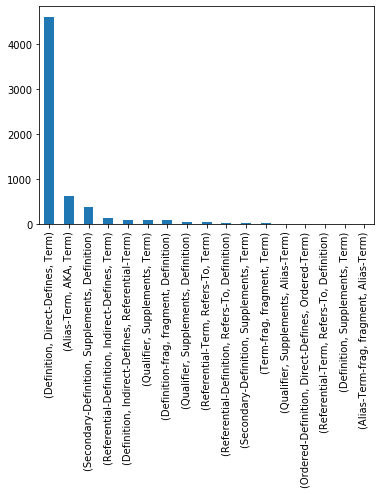

In [25]:
relation_schema_counts=df.query('num_relations > 0')['relation_schemes'].explode().value_counts()
relation_schema_counts.plot.bar()

In [26]:
relation_schema_counts

(Definition, Direct-Defines, Term)                    4618
(Alias-Term, AKA, Term)                                617
(Secondary-Definition, Supplements, Definition)        370
(Referential-Definition, Indirect-Defines, Term)       120
(Definition, Indirect-Defines, Referential-Term)        93
(Qualifier, Supplements, Term)                          92
(Definition-frag, fragment, Definition)                 76
(Qualifier, Supplements, Definition)                    32
(Referential-Term, Refers-To, Term)                     27
(Referential-Definition, Refers-To, Definition)         17
(Secondary-Definition, Supplements, Term)                7
(Term-frag, fragment, Term)                              6
(Qualifier, Supplements, Alias-Term)                     3
(Ordered-Definition, Direct-Defines, Ordered-Term)       3
(Referential-Term, Refers-To, Definition)                2
(Definition, Supplements, Term)                          1
(Alias-Term-frag, fragment, Alias-Term)                 

## Are there any negative examples for the relation extraction?

In [27]:
relations = set()
relations_to_schemas = defaultdict(list)
for schema in relation_schema_counts.index:
    relations_to_schemas[schema[1]].append(schema)
#relations_to_schemas

In [28]:
def count_negatives(schemas, row):
    entities = row['entities']
    relations = row['relations']
    relations = [(r[0], r[2]) for r in relations]
    negative_examples = 0
    for schema in schemas:
        head_type, _, tail_type = schema
        potential_heads = [e[0] for e in entities if e[1] == head_type]
        potential_tails = [e[0] for e in entities if e[1] == tail_type]
        potential_assignments = list(itertools.product(potential_heads, potential_tails))
        free_assignments = [pa for pa in potential_assignments if pa not in relations]
        negative_examples += len(free_assignments)
    return negative_examples

In [29]:
relations_to_negatives = defaultdict(int)
for relation, schemas in relations_to_schemas.items():
    for idx, row in df.iterrows():
        relations_to_negatives[relation] += count_negatives(schemas, row)

In [30]:
relations_to_negatives

defaultdict(int,
            {'Direct-Defines': 3791,
             'AKA': 368,
             'Supplements': 4689,
             'Indirect-Defines': 103,
             'fragment': 47,
             'Refers-To': 386})

## How good is the created split?

In [31]:
train_df = parse_df(train_file)
dev_df = parse_df(dev_file)
train_df['split'] = 'train'
dev_df['split'] = 'dev'
split_df = pd.concat([train_df, dev_df])

In [32]:
split_df[['split',
          'num_sents',
          'num_tokens',
          'num_entities',
          'num_relations',
          'num_inter_sentence_relations']].groupby('split').describe().transpose()

split                                      dev        train
num_sents                    count  711.000000  5872.000000
                             mean     2.545710     2.542405
                             std      0.571955     0.570292
                             min      1.000000     1.000000
                             25%      2.000000     2.000000
                             50%      3.000000     3.000000
                             75%      3.000000     3.000000
                             max      3.000000     3.000000
num_tokens                   count  711.000000  5872.000000
                             mean    64.236287    70.099966
                             std     24.503070    28.295098
                             min      3.000000     1.000000
                             25%     47.500000    51.000000
                             50%     61.000000    66.000000
                             75%     78.000000    85.000000
                             max    158.000000   256.000000
num_entities                 count  711.000000  5872.000000
                             mean     2.170183     2.088556
                             std      1.809368     1.783455
                             min      0.000000     0.000000
                             25%      0.000000     0.000000
                             50%      2.000000     2.000000
                             75%      3.000000     3.000000
                             max      9.000000    12.000000
num_relations                count  711.000000  5872.000000
                             mean     1.059072     1.036274
                             std      0.911213     0.946650
                             min      0.000000     0.000000
                             25%      0.000000     0.000000
                             50%      1.000000     1.000000
                             75%      2.000000     2.000000
                             max      4.000000     7.000000
num_inter_sentence_relations count  711.000000  5872.000000
                             mean     0.092827     0.088896
                             std      0.335407     0.304286
                             min      0.000000     0.000000
                             25%      0.000000     0.000000
                             50%      0.000000     0.000000
                             75%      0.000000     0.000000
                             max      4.000000     3.000000

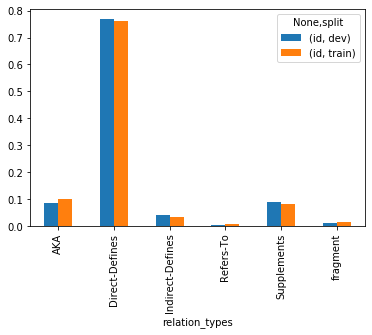

In [33]:
relation_types_by_split = split_df.query('num_relations > 0')[['split', 'relation_types', 'id']].explode('relation_types').groupby(['split', 'relation_types']).count()
relation_types_by_split = relation_types_by_split.unstack(level=0)
relation_types_by_split = relation_types_by_split/relation_types_by_split.sum()
relation_types_by_split.plot.bar()

In [34]:
relation_types_by_split

id          
split                  dev     train
relation_types                      
AKA               0.086220  0.100256
Direct-Defines    0.769053  0.760500
Indirect-Defines  0.040031  0.035075
Refers-To         0.004619  0.007527
Supplements       0.090069  0.083095
fragment          0.010008  0.013548